# Variational Quantum Eigensolvers

Defining new LaTeX commands for bra and ket vectors...
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, transpile, assemble
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP

These are based on the variational principle, as in quantum mechanics. The goal is to find an upper bound on the lowest eigenvalue of some system. It can be shown that for a Hamiltonian $H$ and an arbitrary wavefunction $\ket{\psi}$, the lowest eigenvalue satisfies $$\lambda_{min} \, \leq \, \bra{\psi}H\ket{\psi}.$$ Hence, we can choose an ansatz wavefunction and update it iteratively to obtain bettter and better bound.

For VQE, we would like to be able to generate an arbitrary initial state and construct a "universal circuit"/variational form $U(\theta)$ that can take it to any other state $\ket{\psi(\theta)}$. For a single quibit this is just the $U3(\theta, \phi, \lambda)$ gate. For many qubits, that kind of circuits require a lot of parameters that need to optimized efficiently.

Gradient descent is an intuitive approach, but requires too many evaluations, so it is not best for VQE. A good optimizer is SPSA. which perturbs all the parameters simultaneously in a random fashion.

For noise-free simulations, one can also use COBYLA and SLSQP optimizers.

## Single qubit example

Here we generate a random 2-component vector $\vec{x}$ and try to find a quantum circuit that produces a state close to $\vec{x}$.

In [2]:
target_distr = np.random.rand(2) # Generate a random 2-component vector
target_distr /= np.sum(target_distr) # Normalize the vector
print(target_distr)

[0.63471494 0.36528506]


Define a function that returns a QuantumCircuit object. The function takes in parameters of the circuit as an argument. In this case the circuit produced is a simple U3 gate.

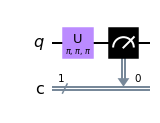

In [3]:
# Define the quantum circuit with the U3 gate
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    qc.u(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc

test_circ = get_var_form([np.pi, np.pi, np.pi])
test_circ.draw('mpl')

Here we define the objective function which performs the simulation with parameters given as arguments and returns the cost function that is to be minimized:

In [4]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

# Converts counts into probabilities
def get_probability_distribution(counts):
    # Divide by NUM_SHOTS to get probabilities
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    
    # In case there is only one possible final state
    if len(output_distr) == 1:
        output_distr.append(1 - output_distr[0])
    return output_distr

def objective_function(params):
    # Obtain a quantum circuit instance from the parameters
    qc = get_var_form(params)
    
    # Execute the quantum circuit to obtain the probability distribution
    # associated with the current parameters
    t_qc = transpile(qc, backend)
    qobj = assemble(t_qc, shots=NUM_SHOTS)
    result = backend.run(qobj).result()
    
    # Obtain the counts for each measured state, and convert those counts
    # into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    
    # Calculate the cost as the distance between the output distribution
    # and the target distribution
    cost = sum([np.abs(output_distr[i] - target_distr[i])
                for i in range(2)])
    
    return cost

Perform the actual calculation by using the COBYLA optimizer on our objective function, starting with random parameters:

In [5]:
# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=1000, tol=0.000001)

# Create the initial parameters (our 1-qubit variational form has 3 parameters)
params = np.random.rand(3)

# Perform the optimization
ret = optimizer.optimize(num_vars=3,
                         objective_function=objective_function,
                         initial_point=params)

# Obtain the output distribution using the final parameters
qc = get_var_form(ret[0])
t_qc = transpile(qc, backend)
qobj = assemble(t_qc, shots=NUM_SHOTS)
counts = backend.run(qobj).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

Target Distribution: [0.63471494 0.36528506]
Obtained Distribution: [0.6412, 0.3588]
Output Error (Manhattan Distance): 0.02377012723873073
Parameters Found: [1.2821412  0.8776622  0.63773462]


## Common variational forms

It is not possible to generate all the states from a polynomially parametrized variational form. Two ways to solve it:
- Domain-specific knowledge (Coupled-Cluster theory, Hartreee-Fock)
- Heuristic circuits (RyRz, Ry, SwapRz)

Here is an example of a circuit for RyRz with different entanglement types:

=============Linear Entanglement:=============


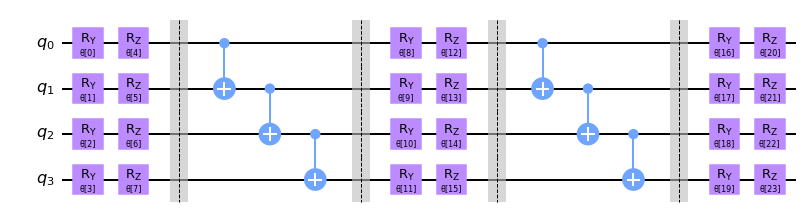


=============Full Entanglement:=============


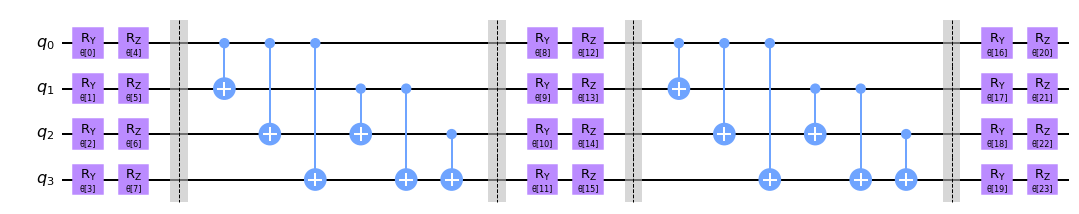


=============Circular Entanglement:=============


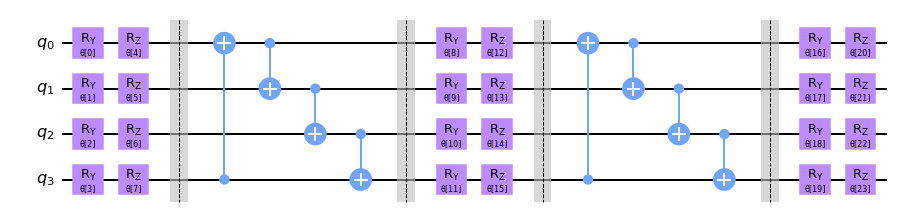


=============SCA Entanglement:=============


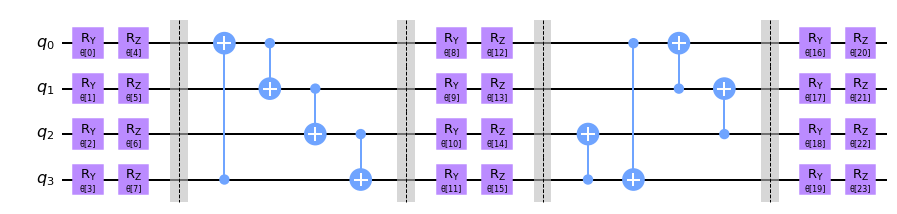

In [6]:
# Efficirnt SU(2) circuit consists of layers of single qubit operations
# spanned by SU(2) and CNOT entanglements
from qiskit.circuit.library import EfficientSU2

entanglements = ["linear", "full", "circular", "sca"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=4, entanglement=entanglement,
                        insert_barriers=True, reps=2, # 2 repetitions
                        su2_gates=['ry','rz']) # Choose the form
    
    if entanglement == "linear":
        print("=============Linear Entanglement:=============")
    elif entanglement == "full":
        print("=============Full Entanglement:=============")
    elif entanglement == "circular":
        print("=============Circular Entanglement:=============")
    else:
        print("=============SCA Entanglement:=============")

    # We initialize all parameters to 0 for this demonstration
    display(form.decompose().draw(output='mpl', fold = 25))
    print()

## Simple VQE example on $H_2$

We present a very simple example of using VQE to find the ground state enery of an $H_2$ molecule:

In [2]:
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import X, Z, I

In [3]:
num_qubits = 2 # 2 electrons
ansatz = TwoLocal(num_qubits, 'ry', 'cz')
opt = SLSQP(maxiter=1000)
vqe = VQE(ansatz, optimizer=opt)
print("Our parametrised ansatz is:")
display(ansatz.decompose().draw('mpl'))

Our parametrised ansatz is:


<Figure size 705.35x200.667 with 1 Axes>

In [4]:
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend=backend, shots=1024)
vqe.quantum_instance = quantum_instance

In [6]:
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)
print(H2_op.to_matrix().real)

[[-1.06365335  0.          0.          0.1809312 ]
 [ 0.         -1.83696799  0.1809312   0.        ]
 [ 0.          0.1809312  -0.24521829  0.        ]
 [ 0.1809312   0.          0.         -1.06365335]]


In [31]:
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result.eigenvalue.real)

-0.9949861442618428


## VQE for ground state of LiH

We need to import many things...

In [18]:
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel

from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.operators import Z2Symmetries

from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

Define a fnction of interatomic distance 'dist'. It calculates some properties of a molecule through a classical PySCF driver. The core modes are freezed and unoccupied modes are removed. Then a fermionic operator is created from the resulting integrals. It is later transformed into a qubit operator and returned.

In [8]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), # Define atom positions
                         unit=UnitsType.ANGSTROM, # Set units
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run() # QMolecule object
    
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta # no. of electrons = 4
    num_spin_orbitals = molecule.num_orbitals * 2 # Why it gives 12?
    
    # To reduce the number of used qubits, the core orbitals are freezed
    # while the unoccupied are removed
    freeze_list = [0]
    remove_list = [-3, -2]
    # Take modulo 6
    freeze_list = [x % molecule.num_orbitals for x in freeze_list] # [0]
    remove_list = [x % molecule.num_orbitals for x in remove_list] #[3, 4]

    remove_list = [x - len(freeze_list) for x in remove_list] # [2, 3]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)
                    for x in remove_list] # [2, 3, 7, 8]
    freeze_list += [x + molecule.num_orbitals
                    for x in freeze_list] # [0, 6]
    
    # Create a femionic operator
    ferOp = FermionicOperator(h1=molecule.one_body_integrals,
                              h2=molecule.two_body_integrals)
    # Freeze the given modes and provide shifted energy after freezing
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list) # 10
    num_particles -= len(freeze_list) # 2
    # Eliminate the given modes
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list) # 6
    
    # Map fermionic operator to a qubit operator
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    
    total_shift = energy_shift + repulsion_energy
    
    return qubitOp, num_particles, num_spin_orbitals, total_shift

Here we finally run the VQE algorithm:

In [9]:
backend = BasicAer.get_backend("statevector_simulator")

distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []

optimizer = SLSQP(maxiter=5)

for dist in distances:
    # Compute the qubit operator
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    
    # Find the exact energies with NumPy eigensolver
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    
    initial_state = HartreeFock(num_spin_orbitals, num_particles,
                                qubit_mapping='parity')
    var_form = UCCSD(num_orbitals=num_spin_orbitals,
                     num_particles=num_particles,
                     initial_state=initial_state,
                     qubit_mapping='parity')
    
    # Compute energies using VQE
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:",
          vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.039673441337947 Exact Energy: [-7.03973252]
Interatomic Distance: 0.6 VQE Result: -7.3133088798023245 Exact Energy: [-7.31334583]
Interatomic Distance: 0.7 VQE Result: -7.500887034835576 Exact Energy: [-7.50092209]
Interatomic Distance: 0.8 VQE Result: -7.630945410431264 Exact Energy: [-7.63097825]
Interatomic Distance: 0.9 VQE Result: -7.7207810996161905 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.78221160011128 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.823568080841347 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.850666131754318 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.867529586841324 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.876966254560179 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.880979508007194 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.881036616091609 Exact En

Make a plot with the results:

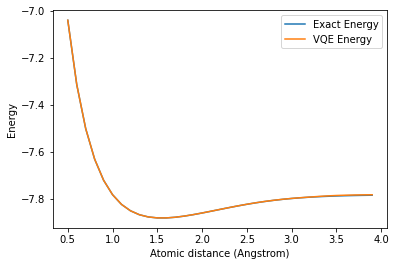

In [10]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

They are so close that there is no visible diffrence!

### VQE for $H_2$ molecule with noise

In [16]:
driver = PySCFDriver(atom='H .0 .0 -0.3625; H .0 .0 0.3625',
                     unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis='sto3g')
molecule = driver.run()
num_particles = molecule.num_alpha + molecule.num_beta # 2

qubitOp = FermionicOperator(h1=molecule.one_body_integrals,
                            h2=molecule.two_body_integrals).mapping(map_type='parity')
qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)

In [25]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = least_busy(provider.backends(simulator=False, operational=True,
                  filters=lambda x: x.configuration().n_qubits == 5))
device.status()

ibmqfactory.load_account:WARNING:2022-07-28 17:23:30,778: Credentials are already in use. The existing account in the session will be replaced.


Load coupling map and noise model from the real IBM device chosen above. Create a QuantumInstance object and enable error mitigation.

In [23]:
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
quantum_instance = QuantumInstance(
    backend=backend,
    shots=8192,
    noise_model=noise_model,
    coupling_map=coupling_map,
    measurement_error_mitigation_cls=CompleteMeasFitter,
    cals_matrix_refresh_period=30)

Compute the exact solution via NuPy eigensolver and the VQE solution:

In [24]:
# Find the exact solution
exact_solution = NumPyEigensolver(qubitOp).run()
print("Exact Result:", np.real(exact_solution.eigenvalues)
      + molecule.nuclear_repulsion_energy)

# Find the solution using VQE
optimizer = SPSA(maxiter=100) # Good for noisy simulation
var_form = EfficientSU2(qubitOp.num_qubits, entanglement="linear") # RyRz
vqe = VQE(qubitOp, var_form, optimizer=optimizer)
ret = vqe.run(quantum_instance)
vqe_result = np.real(ret['eigenvalue']
                     + molecule.nuclear_repulsion_energy)
print("VQE Result:", vqe_result)

Exact Result: [-1.13722138]
VQE Result: -1.0328991920049397
